In [37]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../')
import qtm.base, qtm.constant, qtm.nqubit, qtm.fubini_study
from scipy.linalg import block_diag

In [2]:
# Init parameters
num_qubits = 3
# For arbitrary initial state
num_layers = 1
thetas_origin = np.random.uniform(low = 0, high = 2*np.pi, size = num_qubits*num_layers*5)
# For determine GHZ state
theta = np.random.uniform(0, 2*np.pi)

In [33]:
def calculate_fubini_study_linear_state(qc: qiskit.QuantumCircuit, thetas, num_layers: int = 1):
    """Create linear ansatz and compuate g each sub-layer

    Args:
        qc (qiskit.QuantumCircuit): Init circuit (blank)
        thetas (Numpy array): Parameters
        n_layers (Int): numpy of layers

    Returns:
        qiskit.QuantumCircuit
    """
    n = qc.num_qubits
    if isinstance(num_layers, int) != True:
        num_layers = (num_layers['num_layers'])
    if len(thetas) != num_layers * n * 5:
        raise Exception('Number of parameters must be equal n_layers * num_qubits * 5')
    for i in range(0, num_layers):
        phis = thetas[i:(i + 1)*n*5]
        index_layer = 0
        gs = []

        qc_copy = qtm.nqubit.create_rx_nqubit(qc.copy(), phis[:n])
        observers = (qtm.base.create_observers(qc_copy))[index_layer]
        gs.append(qtm.fubini_study.calculate_g(qc, observers))
        qc = qtm.nqubit.create_rx_nqubit(qc, phis[:n])
        index_layer += 1

        qc_copy = qtm.nqubit.create_cry_nqubit_inverse(qc.copy(), phis[n:n*2])
        observers = (qtm.base.create_observers(qc_copy))[index_layer]
        gs.append(qtm.fubini_study.calculate_g(qc, observers))
        qc = qtm.nqubit.create_cry_nqubit_inverse(qc, phis[n:n*2])
        index_layer += 1


        qc_copy = qtm.nqubit.create_rz_nqubit(qc.copy(), phis[n*2:n*3])
        observers = (qtm.base.create_observers(qc_copy))[index_layer]
        gs.append(qtm.fubini_study.calculate_g(qc, observers))
        qc = qtm.nqubit.create_rz_nqubit(qc, phis[n*2:n*3])
        index_layer += 1


        qc_copy = qtm.nqubit.create_cry_nqubit(qc.copy(), phis[n*3:n*4])
        observers = (qtm.base.create_observers(qc_copy))[index_layer]
        gs.append(qtm.fubini_study.calculate_g(qc, observers))
        qc = qtm.nqubit.create_cry_nqubit(qc, phis[n*3:n*4])
        index_layer += 1


        qc_copy = qtm.nqubit.create_rz_nqubit(qc.copy(), phis[n*4:n*5])
        observers = (qtm.base.create_observers(qc_copy))[index_layer]
        gs.append(qtm.fubini_study.calculate_g(qc, observers))
        qc = qtm.nqubit.create_rz_nqubit(qc, phis[n*4:n*5])
        index_layer += 1
    G = gs[0]
    for i in range(1, len(gs)):
        G = block_diag(G, gs[i])

    return G

In [34]:
thetas = thetas_origin.copy()
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
G = calculate_fubini_study_linear_state(qc, thetas, num_layers)

x = np.eye(15)
print("Before adding noise: ", np.trace(x + np.linalg.inv(G)))

G = G + 10**(-10)*np.identity(G.shape[0])
print("After adding noise: ", np.trace(x + np.linalg.inv(G)))

# If G and (G + noise) return the same results, that means G is OK!

Before adding noise:  (165.08929640072927+0j)
After adding noise:  (165.08929607321127+0j)


In [46]:
thetas = thetas_origin.copy()
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)

loss_values = []
for i in range(0, 100):
    G = calculate_fubini_study_linear_state(qc.copy(), thetas, num_layers)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_GHZchecker_linear, 
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers, theta = theta)
    thetas = np.real(thetas - qtm.constant.learning_rate*(np.linalg.inv(G) @ grad_loss))

    qc_copy = qtm.nqubit.create_GHZchecker_linear(qc.copy(), thetas, num_layers, theta)
    loss = qtm.base.loss_basis(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)



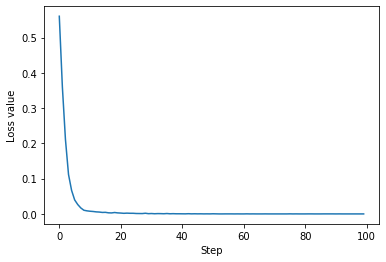

In [47]:
# Plot loss value in 100 steps
plt.plot(loss_values)
plt.xlabel("Step")
plt.ylabel("Loss value")
plt.show()

In [48]:
thetas = thetas_origin.copy()
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)

thetass, loss_values_sgd = qtm.base.fit(
    qc, num_steps = 100, thetas = thetas, 
    create_circuit_func = qtm.nqubit.create_GHZchecker_linear, 
    grad_func = qtm.base.grad_loss,
    loss_func = qtm.base.loss_basis,
    optimizer = qtm.base.sgd,
    verbose = 1,
    is_return_all_thetas = True,
    num_layers = num_layers,
    theta = theta
)


Step: 100%|██████████| 100/100 [08:52<00:00,  5.33s/it]


In [50]:
thetas = thetas_origin.copy()
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)

thetass, loss_values_adam = qtm.base.fit(
    qc, num_steps = 100, thetas = thetas, 
    create_circuit_func = qtm.nqubit.create_GHZchecker_linear, 
    grad_func = qtm.base.grad_loss,
    loss_func = qtm.base.loss_basis,
    optimizer = qtm.base.adam,
    verbose = 1,
    is_return_all_thetas = True,
    num_layers = num_layers,
    theta = theta
)


Step: 100%|██████████| 100/100 [09:08<00:00,  5.49s/it]


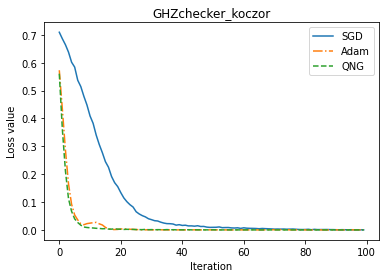

In [54]:

# Plot loss value in 100 steps
plt.plot(loss_values_sgd, label='SGD', linestyle = '-')
plt.plot(loss_values_adam, label='Adam', linestyle = '-.')
plt.plot(loss_values, label='QNG', linestyle = '--')
plt.title('GHZchecker_linear')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.savefig('GHZchecker_linear.png', format='png', dpi=600)
plt.show() 

np.savetxt("./loss_values_sgd.csv", loss_values_sgd, delimiter=",")
np.savetxt("./loss_values_adam.csv", loss_values_adam, delimiter=",")
np.savetxt("./loss_values_qng.csv", loss_values, delimiter=",")
